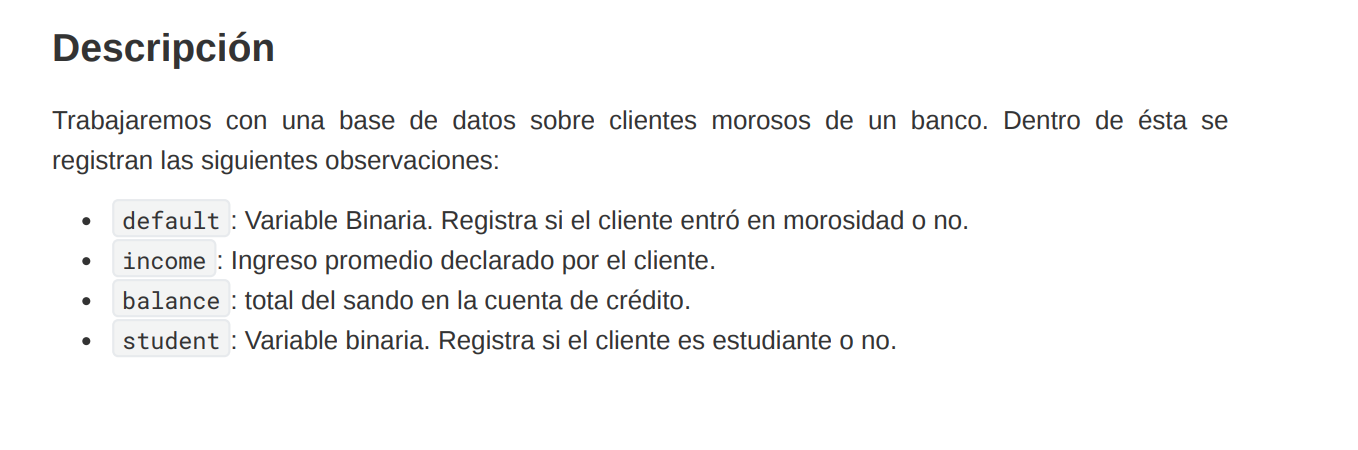

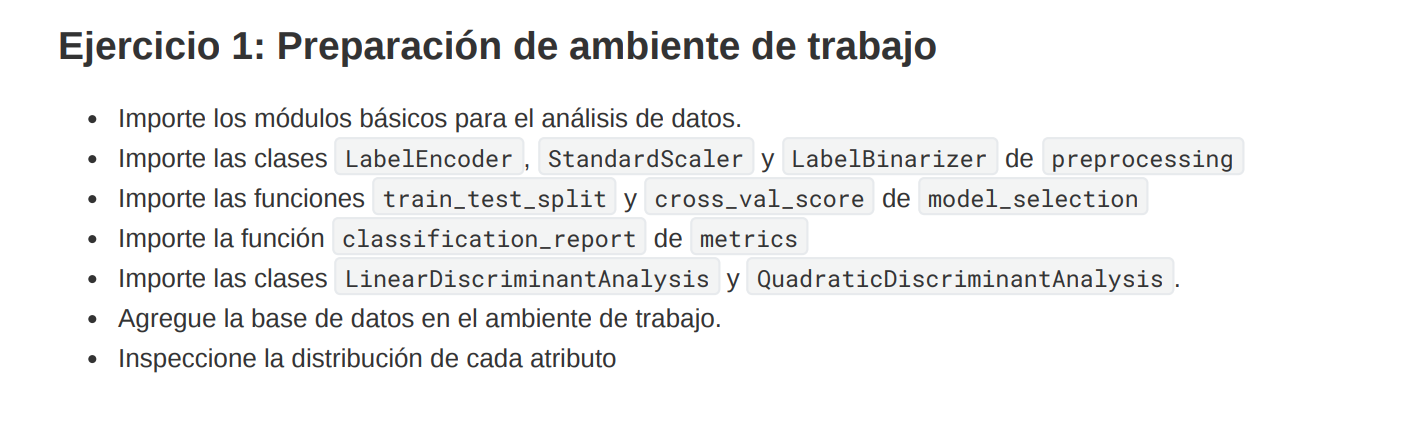

In [1]:
#importe los módulos basicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings

#importe las clases de preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

warnings.filterwarnings(action='ignore')

In [2]:
#agregue la base de datos en el ambiente de trabajo
df = pd.read_csv('default_credit.csv')
df = df.drop('index', axis = 1)
df.head(5)

default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

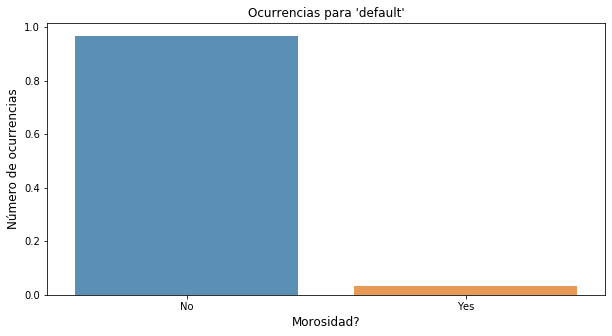

In [3]:
default_count  = df["default"].value_counts("%")

plt.figure(figsize=(10,5))
sns.barplot(default_count.index, default_count.values, alpha=0.8)
plt.title("Ocurrencias para 'default'")
plt.ylabel("Número de ocurrencias", fontsize=12)
plt.xlabel("Morosidad?", fontsize=12)
plt.show()

student_count  = df["student"].value_counts("%")

plt.figure(figsize=(10,5))
sns.barplot(student_count.index, student_count.values, alpha=0.8)
plt.title("Ocurrencias para 'student'")
plt.ylabel("Número de ocurrencias", fontsize=12)
plt.xlabel("Estudiante?", fontsize=12)
plt.show()

### Comentarios: 
- En el gráfico de ocurrencias para default se nota que mas de 90% de los casos son no morosos. 

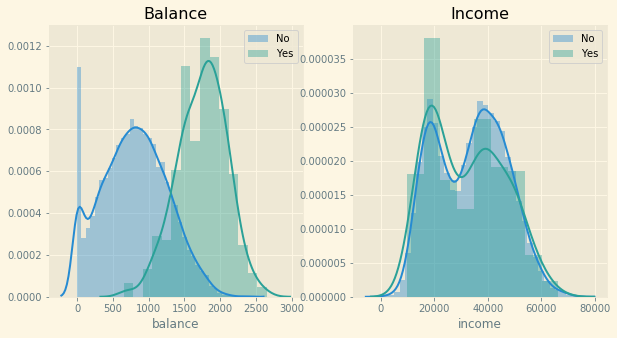

In [4]:
#inspeccione la distribución de cada atributo

plt.style.use("Solarize_Light2")

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
for cat in df["default"].unique():
    sns.distplot(df[df["default"] == cat]["balance"], label = cat)
    plt.title("Balance")
    plt.legend()
plt.subplot(1,2,2)
for cat in df["default"].unique():
    sns.distplot(df[df["default"] == cat]["income"], label = cat)
    plt.title("Income")
    plt.legend()

### Comentatios:

- **Balance** y **Income** parece tener una distribución normal.

In [5]:
#transformamos default y student con LabelEncoder (0 representa "No" y 1 "si")

label_encoder = LabelEncoder()

df['default'] = label_encoder.fit_transform(df['default'])
df['student'] = label_encoder.fit_transform(df['student'])

df.head(5)

default  student      balance        income
0        0        0   729.526495  44361.625074
1        0        1   817.180407  12106.134700
2        0        0  1073.549164  31767.138947
3        0        0   529.250605  35704.493935
4        0        0   785.655883  38463.495879

In [6]:
y = df['default']
attrs = ['student', 'balance', 'income']

X = StandardScaler().fit_transform(df.loc[:, attrs])

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 93177)

In [7]:
def get_metrics(X_train, y_train, kind = 'LDA', priors = None):
    if kind == 'LDA':
        model = LinearDiscriminantAnalysis(priors=priors)
    else:
        model = QuadraticDiscriminantAnalysis(priors=priors)

    result = model.fit(X_train, y_train)
    y_hat = result.predict(X_test)
    print(classification_report(y_test, y_hat))

    cnf = confusion_matrix(y_test, y_hat) / len(y_test)
    labels = ['Moroso', 'No moroso']
    plt.title('Matriz de confusión')
    sns.heatmap(cnf, xticklabels=labels, yticklabels=labels, annot=True, fmt=".1%", cbar=False, cmap='RdPu');

In [8]:
get_metrics(X_train, y_train)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3173
           1       0.78      0.25      0.38       127

    accuracy                           0.97      3300
   macro avg       0.88      0.62      0.68      3300
weighted avg       0.96      0.97      0.96      3300



### Comentarios:

- Se compararán los modelos usando la métrica f1, enfocándose en la predicción de los clientes morosos. Igualmente se comentarán ambos casos.
 * El modelo clasifica muy bien la clase no moroso *(default = 0)* con un 97% de precisión, y tienen un recall de 100%.
 * Para la clase moroso *(default = 1)* tiene mal desempeño, tiene un recall de un 25%, y una presición 78%. Esto significa que el modelo sólo logra capturar un bajo porcentaje de morosos. El f1 es de 38%. Lo que quiere decir es que muchos clientes que son morosos realmente que fueron clasificados como no morosos.

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3173
           1       0.18      0.93      0.31       127

    accuracy                           0.84      3300
   macro avg       0.59      0.88      0.61      3300
weighted avg       0.97      0.84      0.89      3300



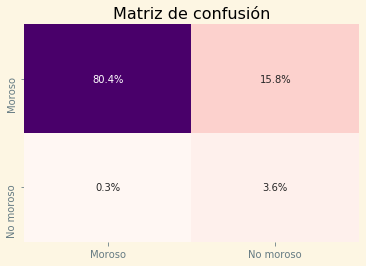

In [9]:
get_metrics(X_train, y_train, priors=[0.5, 0.5])

              precision    recall  f1-score   support

           0       1.00      0.78      0.88      3173
           1       0.15      0.94      0.26       127

    accuracy                           0.79      3300
   macro avg       0.57      0.86      0.57      3300
weighted avg       0.96      0.79      0.85      3300



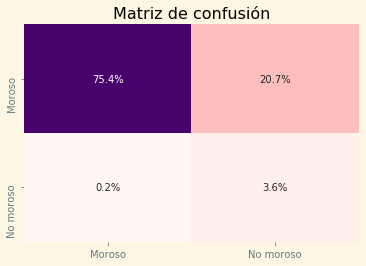

In [10]:
get_metrics(X_train, y_train, priors=[0.4, 0.6])

### Comentarios:

- Ambos modelos mejoran la presición de la clasificación no morosa *(default = 0)*, en comparación del primer caso, 100% para el 50/50 y 100% para el 60/40. El recall bajó a 84% y 78%.
- Para la clase morosa *(default = 1)*, en ambos casos resulta en un aumento grande del recall, hasta un 93% en el caso 50/50 y de 94% en el caso de 60/40. Sin embargo, la precisión bajo tremendamente a menos del 18% en el 50/50. De todas formas el f1 de ambos modelos disminuyó en comparación con el primer modelo.

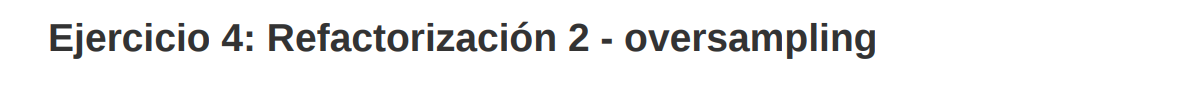

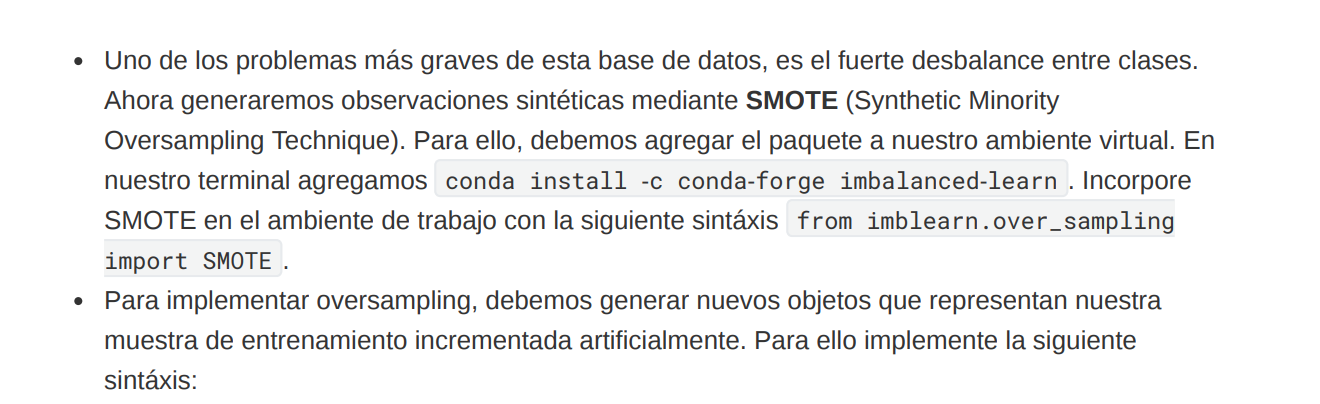

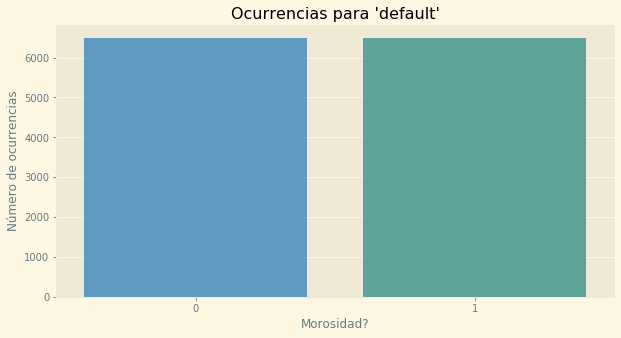

In [11]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state=93177, ratio='minority')

X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

df_oversamp = pd.DataFrame(y_train_oversamp)

default_count  = df_oversamp[0].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(default_count.index, default_count.values, alpha=0.8)
plt.title("Ocurrencias para 'default'")
plt.ylabel("Número de ocurrencias", fontsize=12)
plt.xlabel("Morosidad?", fontsize=12)
plt.show()

### Comentarios:

- Confirma que oversampling aumenta y balancea las muestras 

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3173
           1       0.19      0.93      0.31       127

    accuracy                           0.84      3300
   macro avg       0.59      0.88      0.61      3300
weighted avg       0.97      0.84      0.89      3300



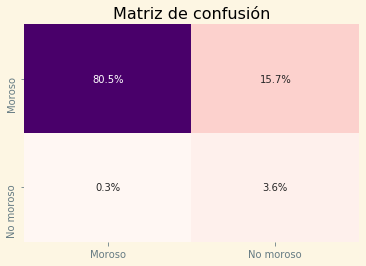

In [12]:
get_metrics(X_train_oversamp, y_train_oversamp)

### Comentarios:

- En clasificación no morosa *(default = 0)*, se mantiene en 100%. El recall mejora levemente a 84%. 
- Para la clase morosa *(default = 1)*, la presición aumentó levemente en comparación con los modelos del punto anterior, el recall sigue en un valor alto 93%. El f1 score mejora, pero el primero modelo sigue con el mejor f1 score. 

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3173
           1       0.20      0.93      0.33       127

    accuracy                           0.86      3300
   macro avg       0.60      0.89      0.63      3300
weighted avg       0.97      0.86      0.90      3300



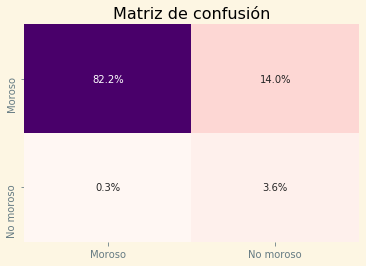

In [13]:
get_metrics(X_train_oversamp, y_train_oversamp, kind='QDA')

### Comentarios:

- La clasificación no morosa *(default = 0)*, se mantiene en el 100% de presición. El recall mejora levemente, a 85%.
- Para la clase morosa, la presición aumentó a 20%, aunque tuvo una leve baja del recall a un valor de 93%. El f1 es de 33%.

# Observaciones generales :

- Se consideró que el objetivo del modelo debe ser predecir a clientes morosos, y se usaría la métrica f1 para la clasificación de clientes morosos. En base a esto el mejor modelo es el modelo base. 

- Aparece un trade-off entre precision y recall para la predicción de "moroso" en los modelos refactorizados que implementamos. A medida que el recall aumentó, disminuía la precisión.